# Assignment 1

### Business Understanding

Introduction - The Iowa Liquor Sales dataset is an API from Google’s Bigquery which contains the spirits purchase detail of Iowa Class “E” liquor license holders by product, date of purchase, and location the item was purchased from. The timeframe of this data starts from January 1, 2012 through 2019. As part of the study commissioned by the Iowa Department of Commerce, all alcoholic sales within the state were logged into the Department system, and in turn, published as open data by the State of Iowa. The dataset contains detail on the name, product, quantity and location of the individual container or package sale. 

1. Set Objectives: We are a new and emerging Whisky brand who specializes in single-malt Rye, and we have targeted the state of Iowa for our next brand expansion. Before doing so, our goal will be to identify and predict which markets are more likely to sell greater volumes of whiskey, so that we can more efficiently spend our marketing dollars and inventory with little waste or buyback. Related questions also include, which brands are going to sell the most in each market, what parts of the year are going to have higher whiskey sales as opposed to lower whiskey sales to optimize advertising dollars, and what features of a town are defining characteristics of a large whiskey seller. 

2. Product Project Plan: To meet our goals, we will first use the Google Bigquery API to access the publicly available Iowa Liquor Sales data via python and Jupyter Notebook. Since the dataset is over 17 million lines of data, we will focus just on 2 months worth of data to do the cleaning. From here, we will define a subset to grant us 30,000 observations, address missing values and begin to build models that could help us answer questions based on markets likely to sell more whiskey. For our data on times of the year when we will sell more whiskey, we will need to create a subset of a full year’s data to build a time series model. For the town features, we will need to include additional information about the zip codes of iowa (such as population, income, ect) to get more demographic detail on each market to assist with a program for a clustering problem. For each of these problems, we will create a training and testing data set to help tune our predictions. 

3. Business Success Criteria - For our prediction models of market sales, we will be consider our model successful if we are able to classify our alochol type with a strong precision, recall and accuracy using a cross validation. Ideally, if we are dealing with 5 alcohol types, we will want to be able to predict whiskey accurately over 20% of the time. 

From the sale price prediction problem, we will run a linear regression technique against the remaining features. For this technique, we will use Root Mean Square Error to evaluate the effectiveness. A strong criteria for performance would be if we can get within $3 as an RMSE.

## Data Mining Type - Describe the meaning and type of data for each attribute in the data file

The data was collected via Google’s BigQuery tool in their Cloud Platform. The data was publicly available within the platform as an educational resource. The data is regularly updated through BigQuery, but .csv files can be found via sites like Kaggle.com. 

The description of all 24 fields of the data attributes can be found at https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy. We are working with the fields to start out with, to help begin the process of feature reduction and correlation analysis. Some of the data has no useful information for analysis, which we will likely be removing eventually. 

Below is a description of each feature available in the data set.

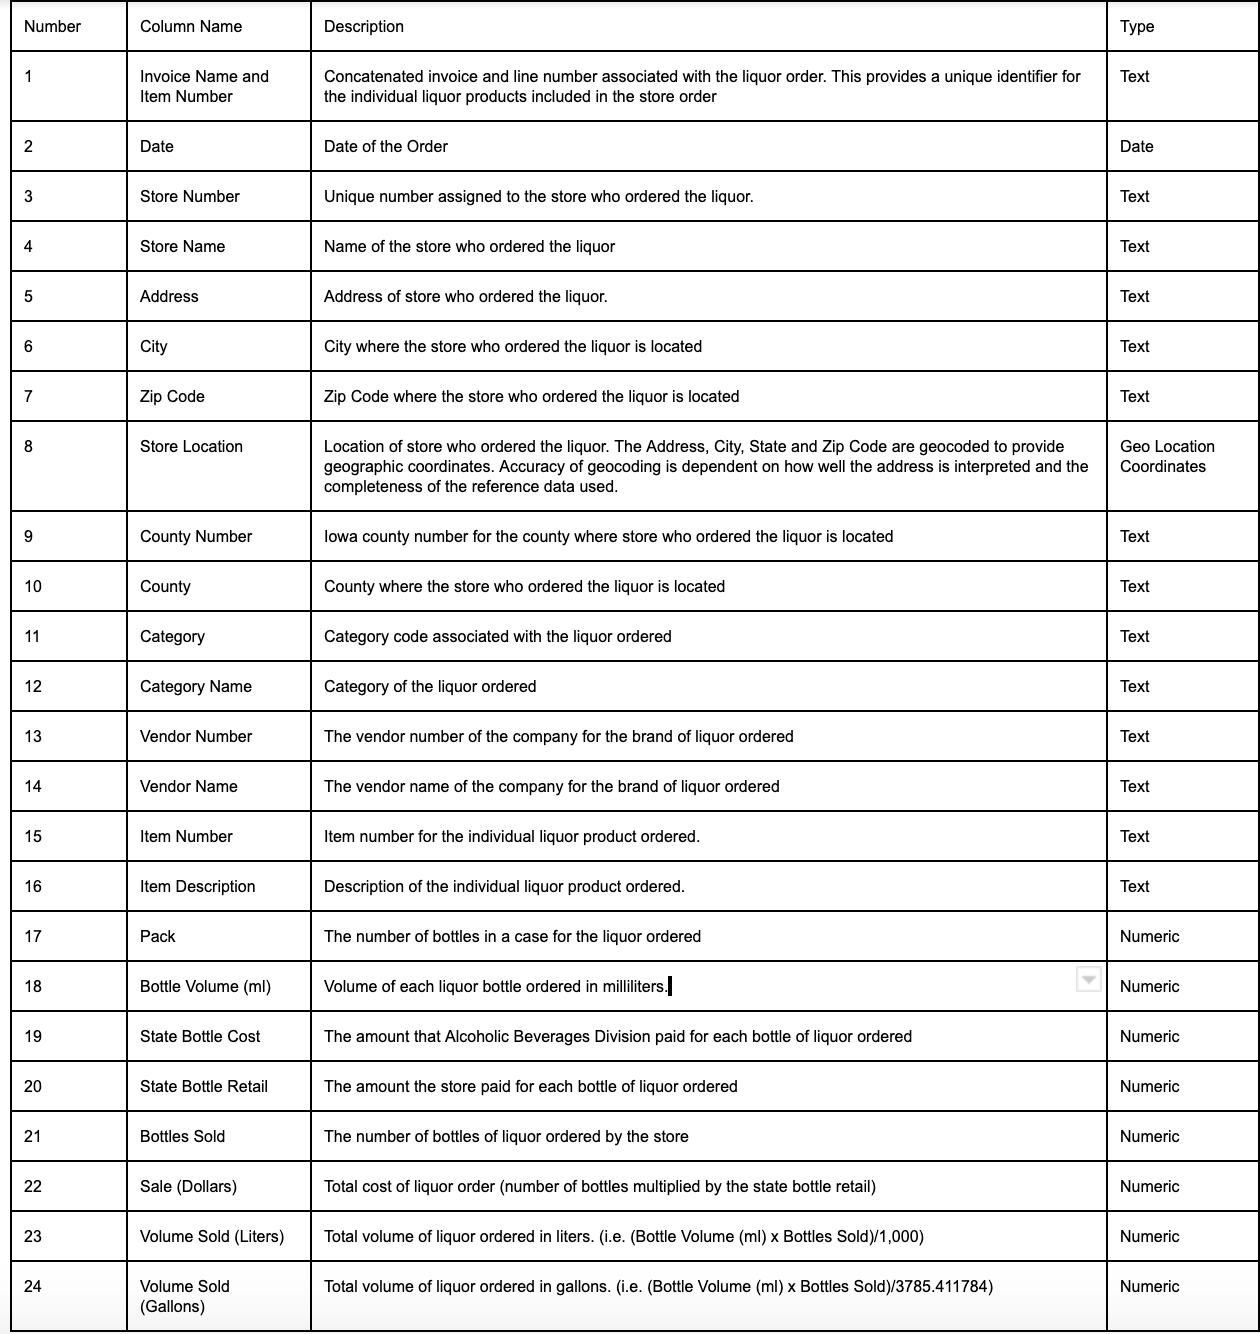

## Data Quality

In [ ]:
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [ ]:

try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re

In [ ]:
from google.cloud import bigquery

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
import os
import pandas as pd

In [ ]:
def implicit():
    from google.cloud import storage

    # This code asks python to look for your credentials in the environment. 
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

### Load in the Data

In order to load in our data, we will need to create a project id and save in our .json credentials from BigQuery onto our local machine. From there, we can set the client variable to map the credentials to our service account in our bigquery program. 

In [ ]:
project = 'macro-campaign-202100'
credentials = service_account.Credentials.from_service_account_file(r'/Users/danielclark/Desktop/SMU/data_mining/My Project-71c2d48ddfb0.json')
#project = 'flash-ward-264717'
#credentials = service_account.Credentials.from_service_account_file(r'/Users/jjsch/Downloads/My Project 35341-372d7a58bfb3.json')
#C:\Users\jjsch\Downloads


client = bigquery.Client(credentials=credentials, project=project)


In [ ]:
begindate = '2012-01-01'
enddate = '2012-03-31'
  
query = "select * FROM `bigquery-public-data.iowa_liquor_sales.sales` where date > '" +begindate + "' and date <= '" + enddate +"' --LIMIT " 
    

df = client.query(query).to_dataframe()

In [ ]:
#df = pd.read_csv("/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv")

For our measurement, we will be querying the first two months of data in 2012 (from Jan 01 through March 01, 2012) using our SQL command limiting our data to the first 30,000 rows. 

In [ ]:
df.info

df.to_csv(index=False)

In [11]:
df.columns.values

array(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'], dtype=object)

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

### Data Cleaning

In our data cleaning step, we need to perform two specific data cleaning operations. 1.) We will need to convert our features to the correct continuous, ordinal and categorical features, and 2.) we will need to address the missing values. 

To begin the process of addressing missing values so that we can convert our data types, we will replace all "?", which our dataset denotes as null, into "-1" values (not strings). From here, we will convert state_bottle_cost, state_bottle_retail, sale_dollars, volume_sold_liters, and volume_sold_gallons into continuous variables so they register as floats. 


In addition, we will need to convert the varaible "bottles_sold" into ordinal features so they register as an integer value in our models. 

Thirdly, we will want to replace the values for pack, bottle_volume_ml, store_number, store_name, address, city, zip_code, county_number, county, category, category_name, vendor_number, vendor_name, item_number and item_description into categorical variables so they register as a non-null object in our model.

Using a df.info function helps to verify this. 

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [12]:
#download to categorize in more summarized manner
#liquortcatlistdf.to_csv("C:\\Users\\jjsch\\downloads\\liquorcats.csv")    
#import the file
liquortcatlistdf = pd.read_csv("/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/liquorcats.csv")

#dfback = pd.merge(dfback, liquortcatlistdf, how = 'left', on='category_name')
df = pd.merge(df, liquortcatlistdf, how = 'left', on='category_name')

In [13]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category
0,S03545900052,2012-01-12,3917,Smokin' Joe's #2 Tobacco and Liquor,1606 W LOCUST ST,DAVENPORT,52804,POINT (-90.599037 41.538254),82,Scott,...,Kahlua Coffee Liqueur,24,375,6.43,9.65,5,48.25,1.88,0.50,Liqueurs
1,S04358000071,2012-03-01,3814,Costco Wholesale #788,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266,POINT (-93.806489 41.561342),25,Dallas,...,Disaronno Amaretto,12,750,12.33,18.99,36,683.64,27.00,7.13,Amaretto
2,S03477100065,2012-01-09,3932,Main Street Spirits / Mapleton,311 MAIN ST,MAPLETON,51034,POINT (-95.79375 42.165915),67,Monona,...,Dekuyper Peachtree,12,1000,7.35,11.02,5,55.10,5.00,1.32,Schnapps
3,S04138200050,2012-02-20,3524,Sam's Club 6568 / Ames,305 AIRPORT RD,AMES,50010,POINT (-93.613648 42.001123),85,Story,...,Juarez Gold Dss,12,1000,4.75,7.13,168,1197.84,168.00,44.38,Whisky
4,S04792600024,2012-03-28,3698,Ingersoll Wine Merchants,1300 50TH ST,WEST DES MOINES,50266,POINT (-93.771159 41.590871),77,Polk,...,Bacardi Multi-Flavor Mini 6 Pack,20,301,3.33,5.00,3,15.00,0.90,0.24,Whisky


In [14]:
#get a few stray not available categories per internet this is tequila
df.loc[df['item_description'] == 'Herradura Gold Reposado 6pak', 'Category'] = "Tequila"
df.loc[df['item_description'] == 'Chambord Liqueur w/2 Glasses', 'Category'] = "Liquers"

#grouping all the store locations into parent stores
df['store_parent'] = 'Other'
df.loc[df['store_name'].str.contains('Hy-Vee'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('Wal-Mart'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('SamsClub'), 'store_parent'] = 'SamsClub'
df.loc[df['store_name'].str.contains('Fareway'), 'store_parent'] = 'Fareway'
df.loc[df['store_name'].str.contains('Kum&Go'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('CVS'), 'store_parent'] = 'CVS'
df.loc[df['store_name'].str.contains('Target'), 'store_parent'] = 'Target'
df.loc[df['store_name'].str.contains('Caseys'), 'store_parent'] = 'Caseys'
df.loc[df['store_name'].str.contains('Dahls'), 'store_parent'] = 'Dahls'
df.loc[df['store_name'].str.contains('WAL-MART'), 'store_parent'] = 'Wal-Mart'
df.loc[df['store_name'].str.contains('HY-VEE'), 'store_parent'] = 'Hy-Vee'
df.loc[df['store_name'].str.contains('KUM&GO'), 'store_parent'] = 'Kum&Go'
df.loc[df['store_name'].str.contains('QuikTrip'), 'store_parent'] = 'QuikTrip'


#labored conversion of dates to month year and month year by converting to strings
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

df.loc[df['month'] ==1 , 'month'] = 'Jan'
df.loc[df['month'] ==2 , 'month'] = 'Feb'
df.loc[df['month'] ==3 , 'month'] = 'Mar'
df.loc[df['month'] ==4 , 'month'] = 'Apr'
df.loc[df['month'] ==5 , 'month'] = 'May'
df.loc[df['month'] ==6 , 'month'] = 'Jun'
df.loc[df['month'] ==7 , 'month'] = 'Jul'
df.loc[df['month'] ==8 , 'month'] = 'Aug'
df.loc[df['month'] ==9 , 'month'] = 'Sep'
df.loc[df['month'] ==10 , 'month'] = 'Oct'
df.loc[df['month'] ==11 , 'month'] = 'Nov'
df.loc[df['month'] ==12 , 'month'] = 'Dec'


df.loc[df['year'] ==2012 , 'year'] = '2012'
df.loc[df['year'] ==2013 , 'year'] = '2013'
df.loc[df['year'] ==2014 , 'year'] = '2014'
df.loc[df['year'] ==2015 , 'year'] = '2015'
df.loc[df['year'] ==2016 , 'year'] = '2016'
df.loc[df['year'] ==2017 , 'year'] = '2017'
df.loc[df['year'] ==2018 , 'year'] = '2018'
df.loc[df['year'] ==2019 , 'year'] = '2019'

#merge year and month together
df['monthyear'] = df['month'] + "-" + df['year']

In [15]:
#df = df.drop(columns=['Category', 'Category_y', 'Category_x'])

In [16]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,S03545900052,2012-01-12,3917,Smokin' Joe's #2 Tobacco and Liquor,1606 W LOCUST ST,DAVENPORT,52804,POINT (-90.599037 41.538254),82,Scott,...,9.65,5,48.25,1.88,0.50,Liqueurs,Other,Jan,2012,Jan-2012
1,S04358000071,2012-03-01,3814,Costco Wholesale #788,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266,POINT (-93.806489 41.561342),25,Dallas,...,18.99,36,683.64,27.00,7.13,Amaretto,Other,Mar,2012,Mar-2012
2,S03477100065,2012-01-09,3932,Main Street Spirits / Mapleton,311 MAIN ST,MAPLETON,51034,POINT (-95.79375 42.165915),67,Monona,...,11.02,5,55.10,5.00,1.32,Schnapps,Other,Jan,2012,Jan-2012
3,S04138200050,2012-02-20,3524,Sam's Club 6568 / Ames,305 AIRPORT RD,AMES,50010,POINT (-93.613648 42.001123),85,Story,...,7.13,168,1197.84,168.00,44.38,Whisky,Other,Feb,2012,Feb-2012
4,S04792600024,2012-03-28,3698,Ingersoll Wine Merchants,1300 50TH ST,WEST DES MOINES,50266,POINT (-93.771159 41.590871),77,Polk,...,5.00,3,15.00,0.90,0.24,Whisky,Other,Mar,2012,Mar-2012


In [17]:
import numpy as np
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'item_description','store_parent', 
                        'monthyear', 'Category']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'bottles_sold']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465033 entries, 0 to 465032
Data columns (total 29 columns):
invoice_and_item_number    465033 non-null object
date                       465033 non-null object
store_number               465033 non-null object
store_name                 465033 non-null object
address                    465033 non-null object
city                       465033 non-null object
zip_code                   465033 non-null object
store_location             421355 non-null object
county_number              464246 non-null object
county                     464246 non-null object
category                   465024 non-null object
category_name              464899 non-null object
vendor_number              465033 non-null object
vendor_name                465033 non-null object
item_number                465033 non-null object
item_description           465033 non-null object
pack                       465033 non-null int64
bottle_volume_ml           465033 non-nu

In [18]:
dfstats = df.describe() # will get summary of continuous or the nominals

# let's set those values to NaN, so that Pandas understand they are missing
df = df.replace(to_replace=-1,value=np.nan) # replace -1 with NaN (not a number)
print (df.info())
dfstats2 = df.describe() # scroll over to see the values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465033 entries, 0 to 465032
Data columns (total 29 columns):
invoice_and_item_number    465033 non-null object
date                       465033 non-null object
store_number               465033 non-null object
store_name                 465033 non-null object
address                    465033 non-null object
city                       465033 non-null object
zip_code                   465033 non-null object
store_location             421355 non-null object
county_number              464246 non-null object
county                     464246 non-null object
category                   465024 non-null object
category_name              464899 non-null object
vendor_number              465033 non-null object
vendor_name                465033 non-null object
item_number                465033 non-null object
item_description           465033 non-null object
pack                       465033 non-null int64
bottle_volume_ml           465033 non-nu

From here, we are going to drop the following variables due to the fact that they will not play a factor in our prediction dataset. Rationale is below:

- store_name : removing due to avail of store_number variable, which will identify the specific store more succinctly
- store location: as we will be able to locate stores on zip code, city and county number, and there appears to be a bunch of nulls anyway.

In [19]:
dfna = df[df.isna().any(axis=1)]
dfna.isna().sum()

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                         0
city                            0
zip_code                        0
store_location              43678
county_number                 787
county                        787
category                        9
category_name                 134
vendor_number                   0
vendor_name                     0
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost              10
state_bottle_retail            10
bottles_sold                    0
sale_dollars                   10
volume_sold_liters              0
volume_sold_gallons             0
Category                   138984
store_parent                    0
month                           0
year                            0
monthyear                       0
dtype: int64

Once we drop our store name, address, and store location variables, we can also look to address the county number nulls as well. Since 112 values is somewhat significant on a 30,000 value dataset, we can look to do some inputation with the other data. 

Since we can use city and zip code as a guide, let's take the values that appear in the respective city and zip code on other values, and replace it with the missing value. 

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 30
# in each column of dataframe
uniqueValues = df.nunique()
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

#Delete categorical columns with > 30 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = df[D_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
df.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

In [20]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,S03545900052,2012-01-12,3917,Smokin' Joe's #2 Tobacco and Liquor,1606 W LOCUST ST,DAVENPORT,52804,POINT (-90.599037 41.538254),82,Scott,...,9.65,5.0,48.25,1.88,0.50,Liqueurs,Other,Jan,2012,Jan-2012
1,S04358000071,2012-03-01,3814,Costco Wholesale #788,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266,POINT (-93.806489 41.561342),25,Dallas,...,18.99,36.0,683.64,27.00,7.13,Amaretto,Other,Mar,2012,Mar-2012
2,S03477100065,2012-01-09,3932,Main Street Spirits / Mapleton,311 MAIN ST,MAPLETON,51034,POINT (-95.79375 42.165915),67,Monona,...,11.02,5.0,55.10,5.00,1.32,Schnapps,Other,Jan,2012,Jan-2012
3,S04138200050,2012-02-20,3524,Sam's Club 6568 / Ames,305 AIRPORT RD,AMES,50010,POINT (-93.613648 42.001123),85,Story,...,7.13,168.0,1197.84,168.00,44.38,Whisky,Other,Feb,2012,Feb-2012
4,S04792600024,2012-03-28,3698,Ingersoll Wine Merchants,1300 50TH ST,WEST DES MOINES,50266,POINT (-93.771159 41.590871),77,Polk,...,5.00,3.0,15.00,0.90,0.24,Whisky,Other,Mar,2012,Mar-2012


In [21]:
df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]

,store_location,county_number,county,category,category_name,state_bottle_cost,state_bottle_retail,sale_dollars,Category
5,None,07,Black Hawk,1081335,RASPBERRY SCHNAPPS,4.37,6.56,32.80,Schnapps
37,None,91,Warren,1081312,BUTTERSCOTCH SCHNAPPS,7.35,11.02,55.10,Schnapps
51,POINT (-93.596754 41.554101),77,Polk,1022200,None,19.59,30.89,556.02,Tequila
57,None,77,Polk,1081030,COFFEE LIQUEURS,6.80,10.20,183.60,Liqueurs
65,None,77,Polk,1701100,DECANTERS & SPECIALTY PACKAGES,59.92,89.88,179.76,Whisky
...,...,...,...,...,...,...,...,...,...
465028,POINT (-94.829963 43.402096),32,Emmet,1082900,MISC. IMPORTED CORDIALS & LIQUEURS,14.93,22.39,89.56,NaN
465029,POINT (-91.56837200000001 43.08605),03,Allamakee,1082900,MISC. IMPORTED CORDIALS & LIQUEURS,14.93,22.39,89.56,NaN
465030,POINT (-93.59704 41.594713),77,Polk,1082900,MISC. IMPORTED CORDIALS & LIQUEURS,25.54,38.31,153.24,NaN
465031,POINT (-95.027238 40.739231),73,Page,1082900,MISC. IMPORTED CORDIALS & LIQUEURS,14.93,22.39,89.56,NaN


#one hot encoding

df = df.drop(columns=['month', 'year'])
#Isolate continuous and categorical data types
#These are indexers into the schoolData dataframe and may be used similar to the schoolData dataframe 
D_boolean = df.loc[:, (df.dtypes == bool) ]
D_nominal = df.loc[:, (df.dtypes == object)]
D_continuous = df.loc[:, (df.dtypes != bool) & (df.dtypes != object)]
print ("Boolean Columns: ", D_boolean.shape[1])
print ("Nominal Columns: ", D_nominal.shape[1])
print ("Continuous Columns: ", D_continuous.shape[1])
print ("Columns Accounted for: ", D_nominal.shape[1] + D_continuous.shape[1] + D_boolean.shape[1])

one_hot_df = pd.concat([pd.get_dummies(df[col],prefix=col) for col in D_nominal.columns], axis=1)
one_hot_df.head()

In [22]:
dfstats2

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,465033.000000,465033.000000,465023.000000,465023.000000,465033.000000,465023.000000,465033.000000,465033.000000
mean,12.244006,942.815437,8.991623,13.514231,9.071872,112.191965,8.497292,2.244849
std,7.359110,464.473531,6.130090,9.196765,19.569498,306.777862,24.555912,6.486981
min,1.000000,12.000000,0.000000,0.000000,1.000000,0.000000,0.070000,0.020000
25%,6.000000,750.000000,5.230000,7.840000,2.000000,27.280000,1.750000,0.460000
50%,12.000000,750.000000,7.580000,11.370000,6.000000,65.160000,4.800000,1.270000
75%,12.000000,1000.000000,11.010000,16.530000,12.000000,125.000000,10.500000,2.770000
max,60.000000,3000.000000,1111.940000,1667.910000,1800.000000,29568.000000,3150.000000,832.140000


In [23]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear
0,S03545900052,2012-01-12,3917,Smokin' Joe's #2 Tobacco and Liquor,1606 W LOCUST ST,DAVENPORT,52804,POINT (-90.599037 41.538254),82,Scott,...,9.65,5.0,48.25,1.88,0.50,Liqueurs,Other,Jan,2012,Jan-2012
1,S04358000071,2012-03-01,3814,Costco Wholesale #788,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266,POINT (-93.806489 41.561342),25,Dallas,...,18.99,36.0,683.64,27.00,7.13,Amaretto,Other,Mar,2012,Mar-2012
2,S03477100065,2012-01-09,3932,Main Street Spirits / Mapleton,311 MAIN ST,MAPLETON,51034,POINT (-95.79375 42.165915),67,Monona,...,11.02,5.0,55.10,5.00,1.32,Schnapps,Other,Jan,2012,Jan-2012
3,S04138200050,2012-02-20,3524,Sam's Club 6568 / Ames,305 AIRPORT RD,AMES,50010,POINT (-93.613648 42.001123),85,Story,...,7.13,168.0,1197.84,168.00,44.38,Whisky,Other,Feb,2012,Feb-2012
4,S04792600024,2012-03-28,3698,Ingersoll Wine Merchants,1300 50TH ST,WEST DES MOINES,50266,POINT (-93.771159 41.590871),77,Polk,...,5.00,3.0,15.00,0.90,0.24,Whisky,Other,Mar,2012,Mar-2012


### Outliers

In [24]:
# this python magics will allow plot to be embedded into the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [25]:
df['Category'].value_counts()


Whisky      154154
Vodka        44646
Rum          40168
Schnapps     20687
Tequila      20453
Gin          18756
Liqueurs     16298
Brandies      6940
Amaretto      3939
Liquers          8
Name: Category, dtype: int64

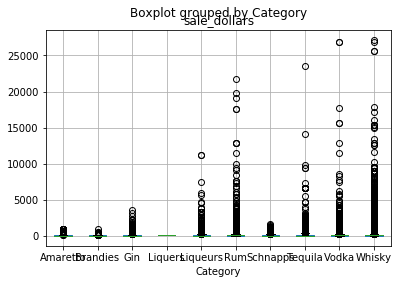

In [26]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df.boxplot(column = 'sale_dollars', by = 'Category')
ax

Looking at a quick boxplot of our 66 categories, along with the sale price, we can see there are a handfull of liquor sales that went north of $5,000, with two who have exceeded $25,000.

In [30]:
# selecting rows based on condition
exp_df = df[df['sale_dollars'] > 20000]

exp_df['cost_per_liter'] = exp_df['sale_dollars']/exp_df['volume_sold_liters']

print(exp_df[['sale_dollars', 'volume_sold_liters', 'cost_per_liter', 'Category']])

        sale_dollars  volume_sold_liters  cost_per_liter Category
6446         21766.8              1320.0       16.490000      Rum
131704       23478.0               450.0       52.173333  Tequila
222159       26808.0              1200.0       22.340000    Vodka
236793       27183.0              1020.0       26.650000   Whisky
236936       26856.0              3150.0        8.525714   Whisky
237033       25584.0               960.0       26.650000   Whisky
307375       26808.0              1200.0       22.340000    Vodka
405901       25584.0               960.0       26.650000   Whisky
412294       29568.0              1200.0       24.640000      NaN


/Users/danielclark/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


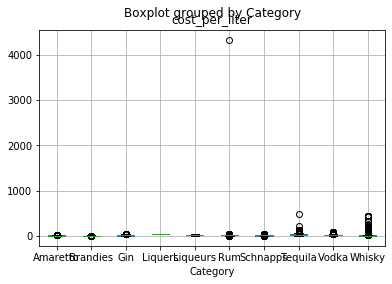

In [31]:
df['cost_per_liter'] = df['sale_dollars']/df['volume_sold_liters']


bx = df.boxplot(column = 'cost_per_liter', by = 'Category')
bx

## Simple Statistics

The df.describe funciton below provides some simple statistcs for the numeric values in the table. 

We can see that the average pack size is just over 12, with a median of exactly 12, so this would suggest our normality curve is very narrow (verified with the SD of 7.3 bottles and slightly right-skewed towards higher pack sizes. 

The average sale in our data set is $116.42 with a standard deviation of $415.62, which suggests there's a very wide variance of case prices in our data set. The median was $65.96 which suggests there are a few outliers in our data set for sales. Per our describe functions, the max sale was $27,183

All of our data has at least a count of 29,999 out of 30,000, with state_bottle_cost, state_bottle_retail, and sale_dollars.

In [ ]:
df.describe()

In [34]:
#calculate mode

df.mode()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear,cost_per_liter
0,381800001,2012-03-13,2190,"Central City Liquor, Inc.",1460 2ND AVE,DES MOINES,52240,POINT (-93.619787 41.60566),77,Polk,...,12.0,152.88,9.0,2.38,Whisky,Other,Mar,2012,Mar-2012,12.986667
1,381800002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,381800003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,381800004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,381800005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465028,S04814700006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465029,S04814700007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465030,S04814700008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465031,S04814700009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize Attributes
The follwong section shows data visualizations between the different attirbutes and the readmission rates for each group of attributes. 



In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465033 entries, 0 to 465032
Data columns (total 30 columns):
invoice_and_item_number    465033 non-null object
date                       465033 non-null object
store_number               465033 non-null object
store_name                 465033 non-null object
address                    465033 non-null object
city                       465033 non-null object
zip_code                   465033 non-null object
store_location             421355 non-null object
county_number              464246 non-null object
county                     464246 non-null object
category                   465024 non-null object
category_name              464899 non-null object
vendor_number              465033 non-null object
vendor_name                465033 non-null object
item_number                465033 non-null object
item_description           465033 non-null object
pack                       465033 non-null int64
bottle_volume_ml           465033 non-nu

In [36]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# now try plotting some of the previous plots, way more visually appealing!!
#https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
sns.pairplot(df)
sns.pairplot(df, hue= 'Category')
sns.pairplot(df, hue='Category', diag_kind = 'kde')

# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

In [37]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Category,store_parent,month,year,monthyear,cost_per_liter
0,S03545900052,2012-01-12,3917,Smokin' Joe's #2 Tobacco and Liquor,1606 W LOCUST ST,DAVENPORT,52804,POINT (-90.599037 41.538254),82,Scott,...,5.0,48.25,1.88,0.50,Liqueurs,Other,Jan,2012,Jan-2012,25.664894
1,S04358000071,2012-03-01,3814,Costco Wholesale #788,7205 MILLS CIVIC PKWY,WEST DES MOINES,50266,POINT (-93.806489 41.561342),25,Dallas,...,36.0,683.64,27.00,7.13,Amaretto,Other,Mar,2012,Mar-2012,25.320000
2,S03477100065,2012-01-09,3932,Main Street Spirits / Mapleton,311 MAIN ST,MAPLETON,51034,POINT (-95.79375 42.165915),67,Monona,...,5.0,55.10,5.00,1.32,Schnapps,Other,Jan,2012,Jan-2012,11.020000
3,S04138200050,2012-02-20,3524,Sam's Club 6568 / Ames,305 AIRPORT RD,AMES,50010,POINT (-93.613648 42.001123),85,Story,...,168.0,1197.84,168.00,44.38,Whisky,Other,Feb,2012,Feb-2012,7.130000
4,S04792600024,2012-03-28,3698,Ingersoll Wine Merchants,1300 50TH ST,WEST DES MOINES,50266,POINT (-93.771159 41.590871),77,Polk,...,3.0,15.00,0.90,0.24,Whisky,Other,Mar,2012,Mar-2012,16.666667


In [ ]:
plt.style.use('ggplot')

df_grouped = df.groupby(by=['store_parent', 'month'])
sales_tot = df_grouped.sale_dollars.sum()
ax = sales_tot.plot(kind = 'barh')

In [ ]:
store_sales = pd.crosstab

## Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.



In [61]:
# calculate the correlation matrix
corr_matrix  = df.corr().abs()

# Select upper triangle of correlation matrix
corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,cost_per_liter
pack,NaN,0.649576,0.361569,0.362662,0.081520,0.061895,0.086327,0.086213,0.054171
bottle_volume_ml,NaN,NaN,0.264465,0.265476,0.006139,0.076012,0.161949,0.161739,0.282379
state_bottle_cost,NaN,NaN,NaN,0.999771,0.057816,0.144690,0.007527,0.007489,0.659935
state_bottle_retail,NaN,NaN,NaN,NaN,0.057838,0.144821,0.007845,0.007807,0.659760
bottles_sold,NaN,NaN,NaN,NaN,NaN,0.863555,0.912853,0.912893,0.053801
sale_dollars,NaN,NaN,NaN,NaN,NaN,NaN,0.846761,0.846777,0.062964
volume_sold_liters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.076670
volume_sold_gallons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076606
cost_per_liter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Doing a simple correlation matrix, we can see that there's a strong collrelation between state_bottle_cost and state_bottle_retail.

In addition, there are positive correlations between the following:
Pack and bottle_volume_ml - 0.99
volume_sold_liters and bottles sold - 0.91
volume_sold_gallons and bottles sold - 0.91
sale_dollars and bottles_sold - 0.86
sale_dollars and volume_sold_gallons - 0.84
sale_dollars and volume_sold_liters - 0.84


In [63]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]



#Get all of the correlation values > 95%
x = np.where(upper > 0.80)

#Display all field combinations with > 95% correlation
cf = pd.DataFrame()
cf['Field1'] = upper.columns[x[1]]
cf['Field2'] = upper.index[x[0]]

#Get the correlation values for every field combination. (There must be a more pythonic way to do this!)
corr = [0] * len(cf)
for i in range(0, len(cf)):
    corr[i] =  upper[cf['Field1'][i]][cf['Field2'][i]] 
    
cf['Correlation'] = corr

print ('There are ', str(len(cf['Field1'])), ' field correlations > 80%.')
cf

There are  7  field correlations > 80%.


,Field1,Field2,Correlation
0,state_bottle_retail,state_bottle_cost,0.999771
1,sale_dollars,bottles_sold,0.863555
2,volume_sold_liters,bottles_sold,0.912853
3,volume_sold_gallons,bottles_sold,0.912893
4,volume_sold_liters,sale_dollars,0.846761
5,volume_sold_gallons,sale_dollars,0.846777
6,volume_sold_gallons,volume_sold_liters,1.000000


## Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).



## New Features 
Are there other features that could be added to the data or created from existing features? Which ones?



## Exceptional Work 
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.